<a href="https://colab.research.google.com/github/SarahMcEliece/DTSA-5511-Deep-Learning/blob/main/Week%203%20Cancer%20Kaggle/Week_3_Kaggle_project_Histopathologic_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DTSA 5511 Week 3 Mini Project
# Cancer Image Classification

For week 3 of deep learning, I will create a CNN model to identify metisttic cancer. This is a kaggle competiotion, described as:

> Indented block
In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset.




In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image


plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

# Pulling and preprocessing data
First I need to get the data from kaggle, see what format it is in and do some pre-processing.

In [5]:
##Setup pulling data from kaggle
#dowload api token from kaggle profile and upload it to notebook

! pip install kaggle
! mkdir ~/.kaggle
! cp /kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download histopathologic-cancer-detection
! unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

In [6]:
# Get a list of all the image filenames in the dataset directory
train_dir = '/content/train'
image_filenames = os.listdir(train_dir)

# Get image dimensions
image_widths = []
image_heights = []

for image_filename in image_filenames:
    # Open the image using the PIL library
    image = Image.open(os.path.join(train_dir, image_filename))
    width, height = image.size
    image_widths.append(width)
    image_heights.append(height)

# Print the summary statistics of the training image dataset
print('Number of training images:', len(image_filenames))
print('Image dimensions:', np.min(image_widths), 'x', np.min(image_heights), '-', np.max(image_widths), 'x', np.max(image_heights))

Number of training images: 220025
Image dimensions: 96 x 96 - 96 x 96


In [7]:
test_file_li = pd.DataFrame(data={'id':os.listdir('/content/test/')})
print("Number of images in our test data: ",len(test_file_li))

Number of images in our test data:  57458


In [8]:
#upload and sort the training data labels
train_labels_df = pd.read_csv('/content/train_labels.csv')
train_labels_df['id'] = train_labels_df['id'] + '.tif'
train_labels_df['label'] =train_labels_df['label'].astype('str')

print("Distribution of training examples:",train_labels_df['label'].value_counts())
print(train_labels_df.info())

Distribution of training examples: 0    130908
1     89117
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB
None


Label:  0


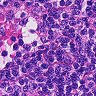

Label:  0


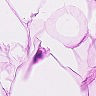

Label:  1


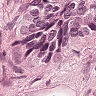

Label:  0


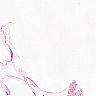

Label:  0


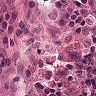

In [9]:
#Print a few example images
for i in range(5):
  data_idx = np.random.randint(len(train_labels_df))
  image = Image.open(os.path.join(train_dir, train_labels_df['id'][data_idx]))
  print("Label: ",train_labels_df['label'][data_idx])
  image.show()

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator        

In [12]:
gen = ImageDataGenerator(validation_split=0.2)
train_gen = gen.flow_from_dataframe(train_labels_df,
                        directory='/content/train/',
                        x_col="id",
                        y_col="label",
                        target_size=(96, 96),
                        subset="training",
                        class_mode="binary")

val_gen = gen.flow_from_dataframe(train_labels_df,
                        directory='/content/train/',
                        x_col="id",
                        y_col="label",
                        target_size=(96, 96),
                        subset="validation",
                        class_mode="binary")

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Building Neural network.
The first thing I'm going to do is try a  simple model with two convolution layers. Mostly, just to make sure I'm doing this even rempotely correct. 

In [30]:
# Build Sequential Model
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 30976)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                

### Model compile


In [32]:
# Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

### Model fit


In [33]:
batch_size = 256
history = model.fit(
        train_gen,
        steps_per_epoch=len(train_gen) // batch_size,
        epochs=100,
        validation_data=val_gen,
        validation_steps=len(val_gen) // batch_size)


Epoch 1/100
21/21 [==============================] - 14s 88ms/step - loss: 173.7934 - accuracy: 0.5491 - val_loss: 0.6906 - val_accuracy: 0.5875
Epoch 2/100
21/21 [==============================] - 2s 82ms/step - loss: 0.6875 - accuracy: 0.6101 - val_loss: 0.6913 - val_accuracy: 0.5312
Epoch 3/100
21/21 [==============================] - 2s 75ms/step - loss: 0.6852 - accuracy: 0.5818 - val_loss: 0.6943 - val_accuracy: 0.5125
Epoch 4/100
21/21 [==============================] - 2s 78ms/step - loss: 0.6784 - accuracy: 0.6027 - val_loss: 0.6712 - val_accuracy: 0.6313
Epoch 5/100
21/21 [==============================] - 2s 99ms/step - loss: 0.6846 - accuracy: 0.5655 - val_loss: 0.6838 - val_accuracy: 0.5688
Epoch 6/100
21/21 [==============================] - 2s 102ms/step - loss: 0.6754 - accuracy: 0.6086 - val_loss: 0.6584 - val_accuracy: 0.6562
Epoch 7/100
21/21 [==============================] - 2s 80ms/step - loss: 0.6726 - accuracy: 0.6057 - val_loss: 0.7025 - val_accuracy: 0.5125
Ep

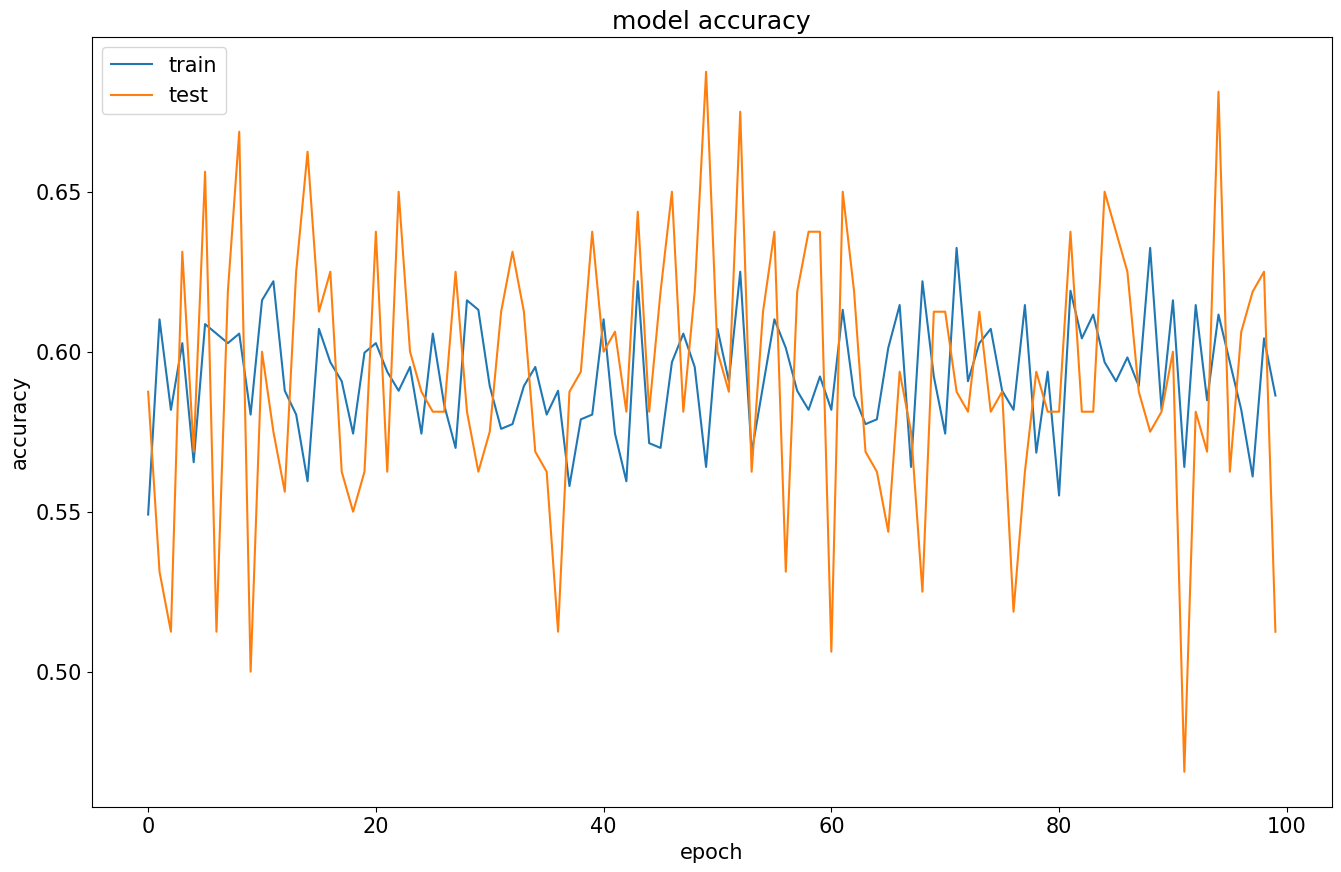

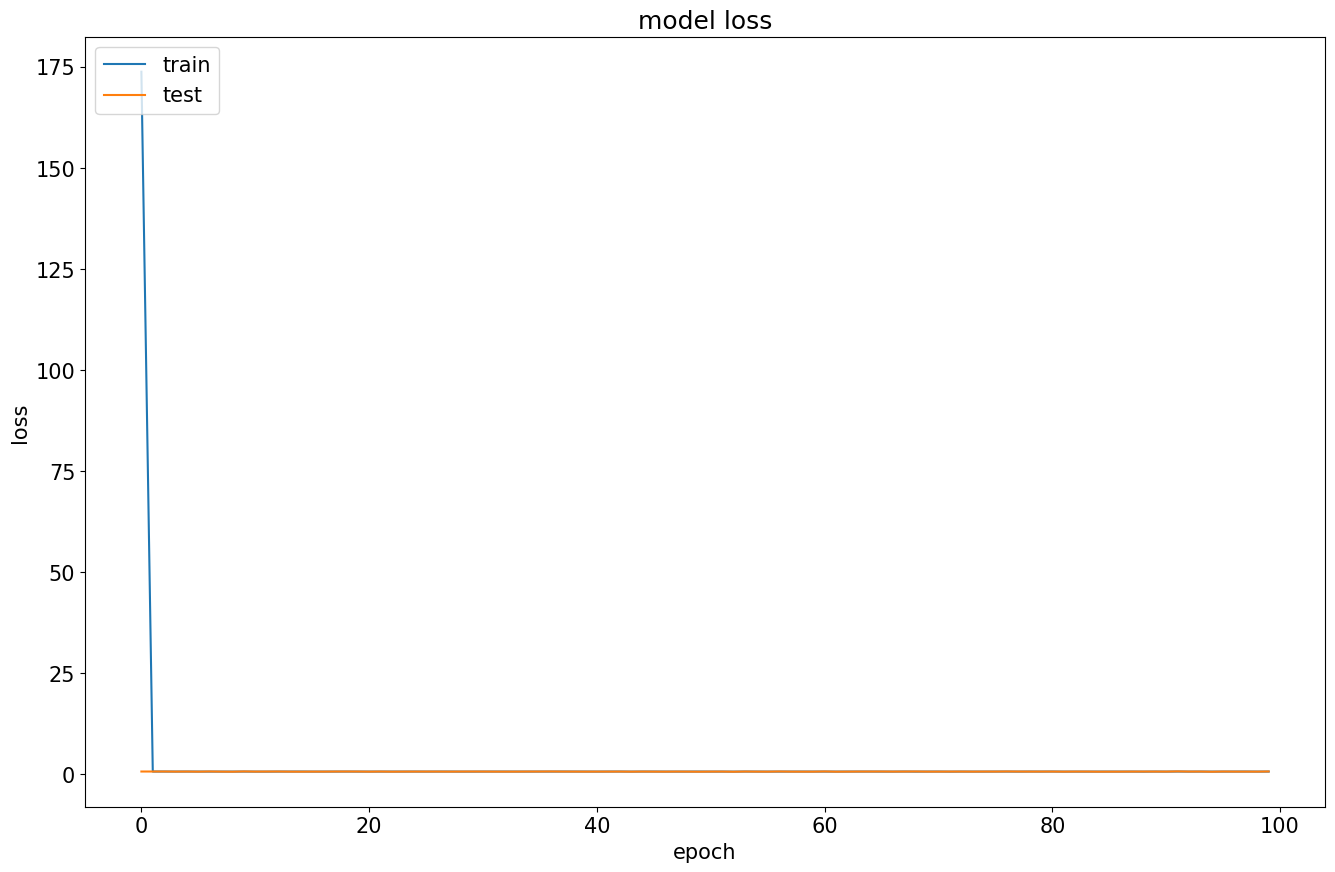

In [36]:
#Let's graph this mess
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# WOW! That was bad! 
Based on the accuracy graph, I think my learning rate was too high, I'll try fixing that first.

Epoch 1/100
21/21 [==============================] - 4s 87ms/step - loss: 0.6850 - accuracy: 0.5670 - val_loss: 0.6690 - val_accuracy: 0.6125
Epoch 2/100
21/21 [==============================] - 2s 79ms/step - loss: 0.6673 - accuracy: 0.6176 - val_loss: 0.6646 - val_accuracy: 0.6250
Epoch 3/100
21/21 [==============================] - 1s 65ms/step - loss: 0.6787 - accuracy: 0.5848 - val_loss: 0.6555 - val_accuracy: 0.6500
Epoch 4/100
21/21 [==============================] - 1s 59ms/step - loss: 0.6808 - accuracy: 0.5789 - val_loss: 0.6800 - val_accuracy: 0.5813
Epoch 5/100
21/21 [==============================] - 1s 61ms/step - loss: 0.6766 - accuracy: 0.5908 - val_loss: 0.6513 - val_accuracy: 0.6625
Epoch 6/100
21/21 [==============================] - 1s 55ms/step - loss: 0.6840 - accuracy: 0.5699 - val_loss: 0.6690 - val_accuracy: 0.6125
Epoch 7/100
21/21 [==============================] - 1s 58ms/step - loss: 0.6640 - accuracy: 0.6265 - val_loss: 0.6489 - val_accuracy: 0.6687
Epoch 

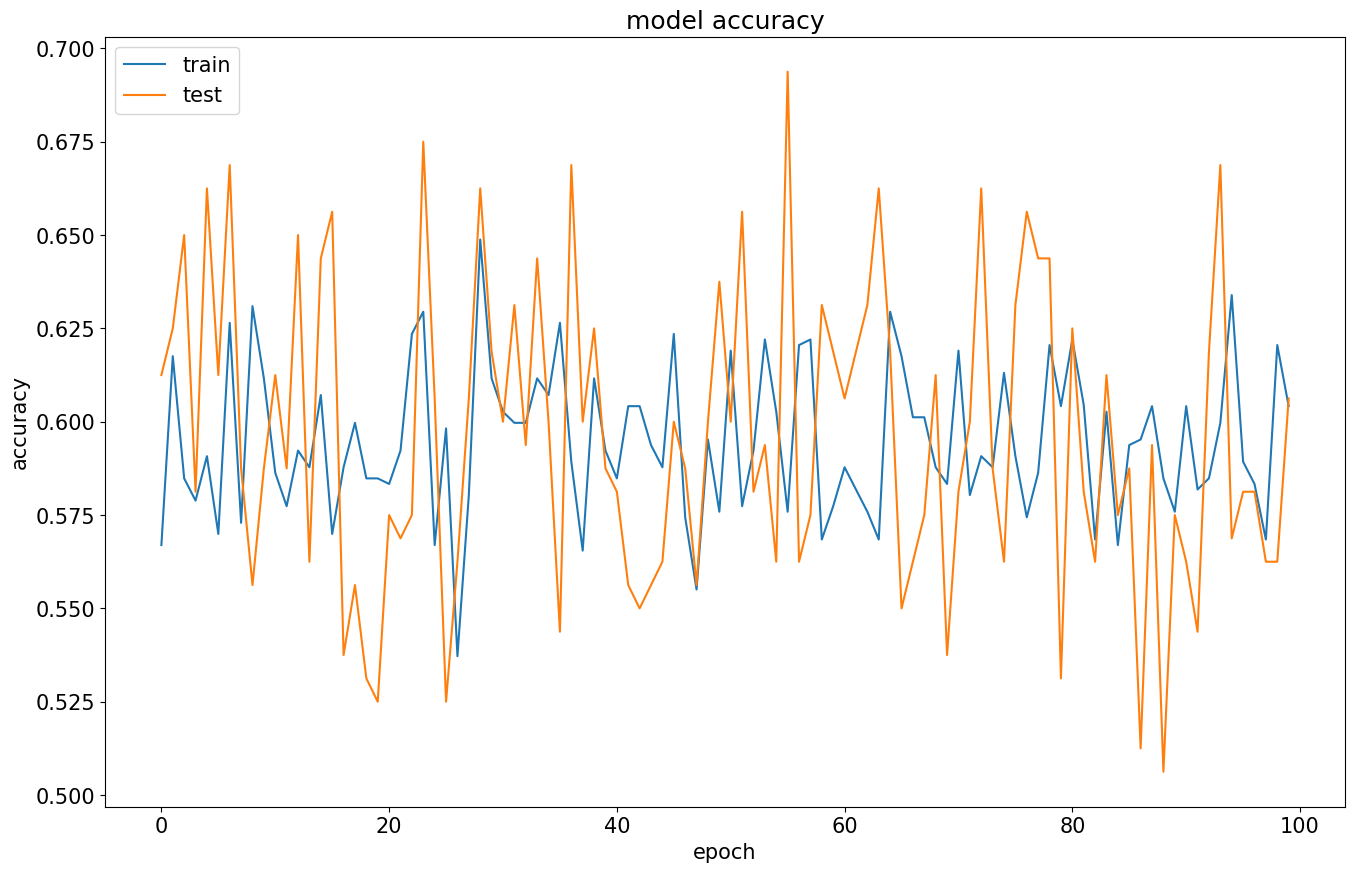

In [38]:
#Updated learning rate from .01 to .001
# Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

batch_size = 256
history = model.fit(
        train_gen,
        steps_per_epoch=len(train_gen) // batch_size,
        epochs=100,
        validation_data=val_gen,
        validation_steps=len(val_gen) // batch_size)

#Let's graph this mess
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Still bad! 
I'm going to add more layers and more filters! I'm basing my initial model on the VGGNet structure. 

Epoch 1/100
21/21 [==============================] - 4s 73ms/step - loss: 14.5073 - accuracy: 0.6071 - val_loss: 0.5098 - val_accuracy: 0.8125
Epoch 2/100
21/21 [==============================] - 2s 76ms/step - loss: 0.5354 - accuracy: 0.7723 - val_loss: 0.5395 - val_accuracy: 0.7563
Epoch 3/100
21/21 [==============================] - 2s 94ms/step - loss: 0.5706 - accuracy: 0.7307 - val_loss: 0.6731 - val_accuracy: 0.6000
Epoch 4/100
21/21 [==============================] - 2s 79ms/step - loss: 0.5317 - accuracy: 0.7440 - val_loss: 0.5030 - val_accuracy: 0.7937
Epoch 5/100
21/21 [==============================] - 2s 73ms/step - loss: 0.5006 - accuracy: 0.7604 - val_loss: 0.5034 - val_accuracy: 0.7750
Epoch 6/100
21/21 [==============================] - 4s 169ms/step - loss: 0.4907 - accuracy: 0.7887 - val_loss: 0.6010 - val_accuracy: 0.6750
Epoch 7/100
21/21 [==============================] - 3s 139ms/step - loss: 0.5511 - accuracy: 0.7366 - val_loss: 0.4963 - val_accuracy: 0.7688
Epo

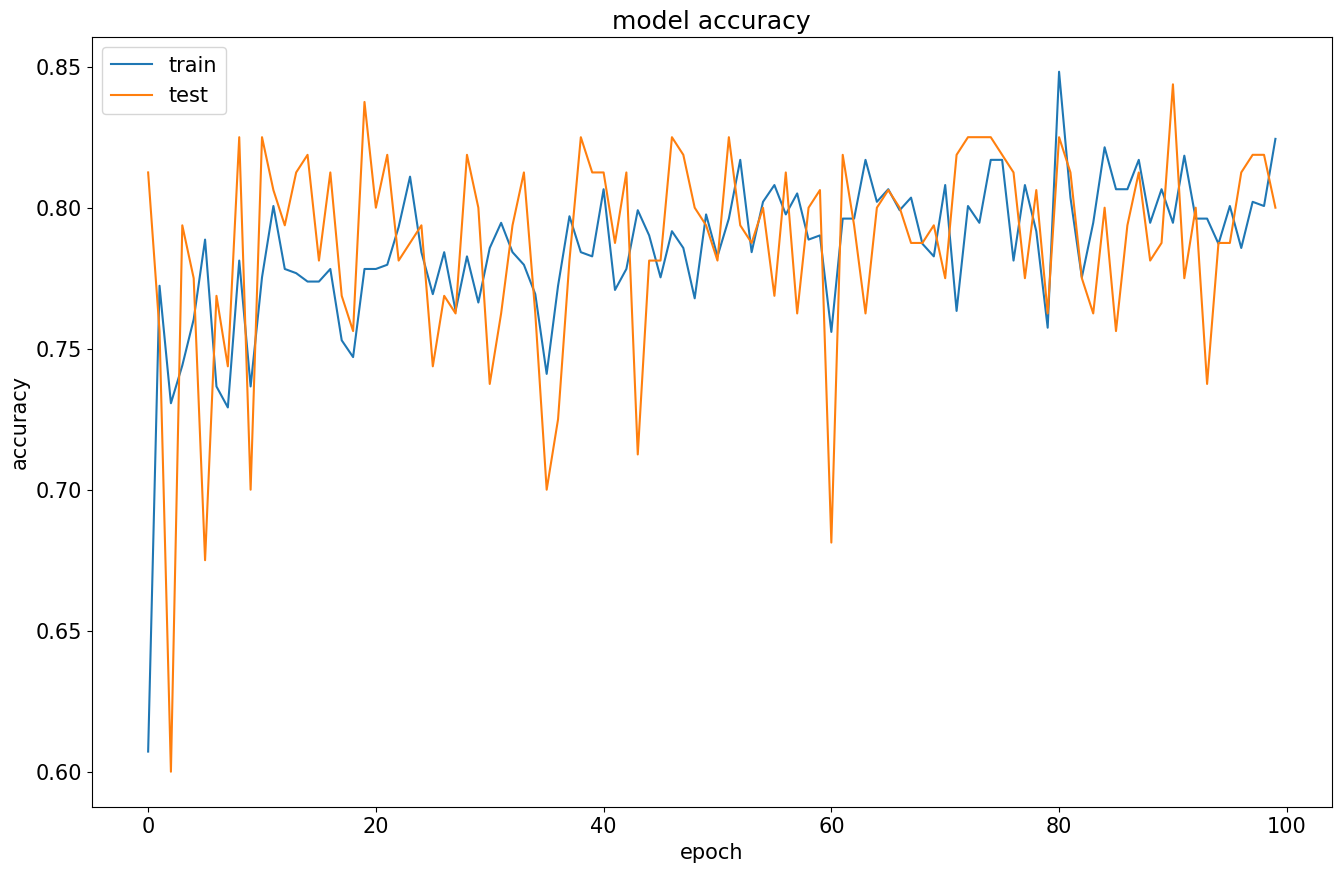

In [43]:
# Build Sequential Model
model2 = tf.keras.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

batch_size = 256
history2 = model2.fit(
        train_gen,
        steps_per_epoch=len(train_gen) // batch_size,
        epochs=100,
        validation_data=val_gen,
        validation_steps=len(val_gen) // batch_size)

#Let's graph this mess
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Hey, at least there is some definite improvement! 
I need to do something about learning rate though, my accuracy is still bouncing al over the place.

Epoch 1/100
21/21 [==============================] - 4s 67ms/step - loss: 0.6724 - accuracy: 0.7485 - val_loss: 0.4348 - val_accuracy: 0.8313
Epoch 2/100
21/21 [==============================] - 1s 58ms/step - loss: 0.4884 - accuracy: 0.7917 - val_loss: 0.4019 - val_accuracy: 0.8438
Epoch 3/100
21/21 [==============================] - 1s 65ms/step - loss: 0.5016 - accuracy: 0.7738 - val_loss: 0.4438 - val_accuracy: 0.8500
Epoch 4/100
21/21 [==============================] - 2s 77ms/step - loss: 0.4918 - accuracy: 0.7723 - val_loss: 0.5432 - val_accuracy: 0.7250
Epoch 5/100
21/21 [==============================] - 2s 84ms/step - loss: 0.4840 - accuracy: 0.7783 - val_loss: 0.4412 - val_accuracy: 0.8000
Epoch 6/100
21/21 [==============================] - 1s 69ms/step - loss: 0.4586 - accuracy: 0.7827 - val_loss: 0.3384 - val_accuracy: 0.8625
Epoch 7/100
21/21 [==============================] - 1s 62ms/step - loss: 0.4731 - accuracy: 0.7946 - val_loss: 0.4281 - val_accuracy: 0.7812
Epoch 

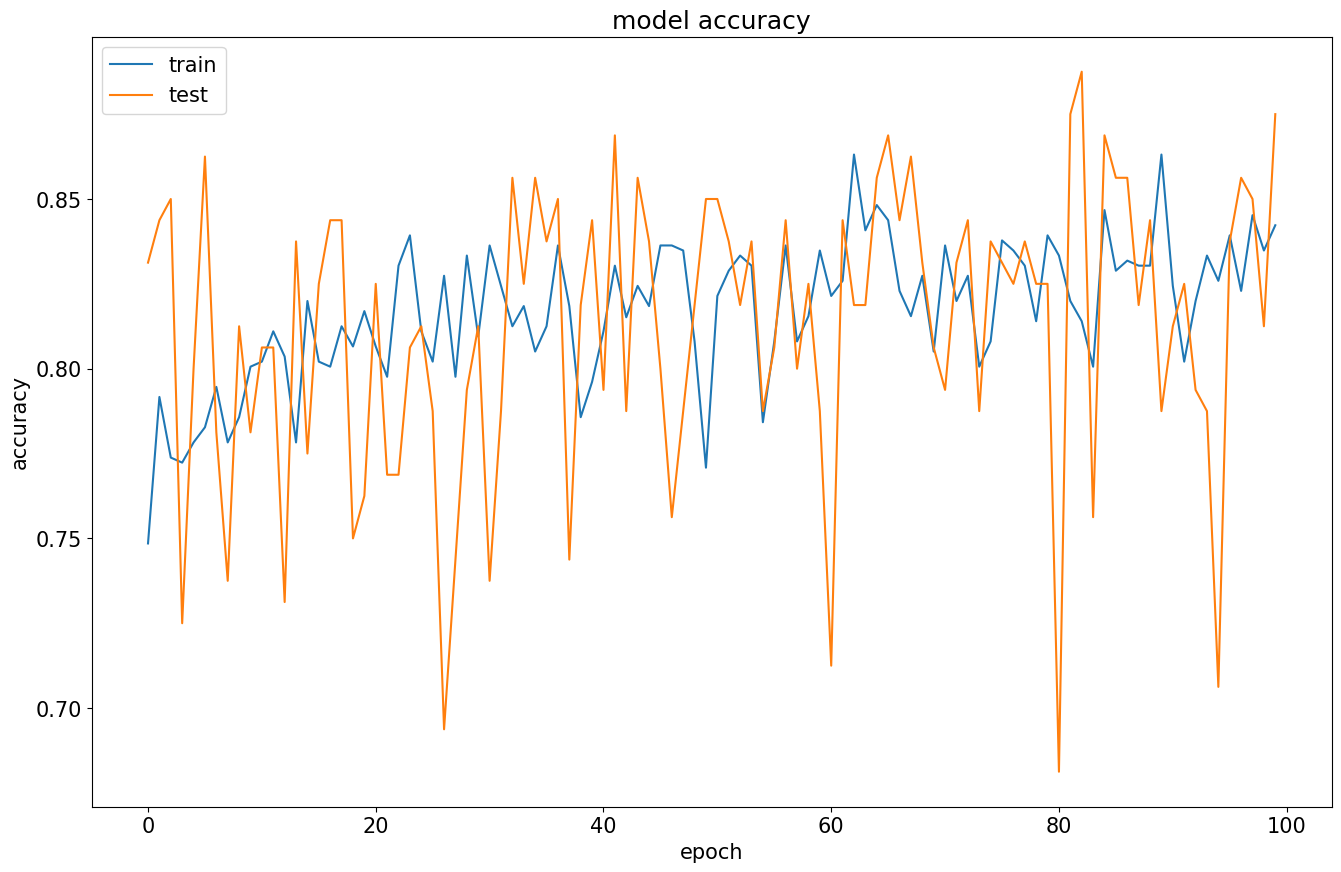

In [47]:
#Changing learnung rate and optimizer
model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

batch_size = 256
history2 = model2.fit(
        train_gen,
        steps_per_epoch=len(train_gen) // batch_size,
        epochs=100,
        validation_data=val_gen,
        validation_steps=len(val_gen) // batch_size)

#Let's graph this mess
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Not really any change
There's so much variation between epochs, I need to do some regularization. I'll try adding some drop out layers. 

Epoch 1/100
21/21 [==============================] - 4s 71ms/step - loss: 34.6576 - accuracy: 0.5312 - val_loss: 0.7727 - val_accuracy: 0.4187
Epoch 2/100
21/21 [==============================] - 1s 65ms/step - loss: 0.9812 - accuracy: 0.5402 - val_loss: 0.6328 - val_accuracy: 0.6625
Epoch 3/100
21/21 [==============================] - 1s 59ms/step - loss: 0.9794 - accuracy: 0.5223 - val_loss: 0.6753 - val_accuracy: 0.5688
Epoch 4/100
21/21 [==============================] - 1s 58ms/step - loss: 0.8225 - accuracy: 0.5551 - val_loss: 0.6189 - val_accuracy: 0.6687
Epoch 5/100
21/21 [==============================] - 1s 61ms/step - loss: 0.8407 - accuracy: 0.5595 - val_loss: 0.7022 - val_accuracy: 0.4187
Epoch 6/100
21/21 [==============================] - 1s 60ms/step - loss: 0.6987 - accuracy: 0.5818 - val_loss: 0.6564 - val_accuracy: 0.6313
Epoch 7/100
21/21 [==============================] - 1s 58ms/step - loss: 0.7396 - accuracy: 0.5164 - val_loss: 0.6506 - val_accuracy: 0.5875
Epoch

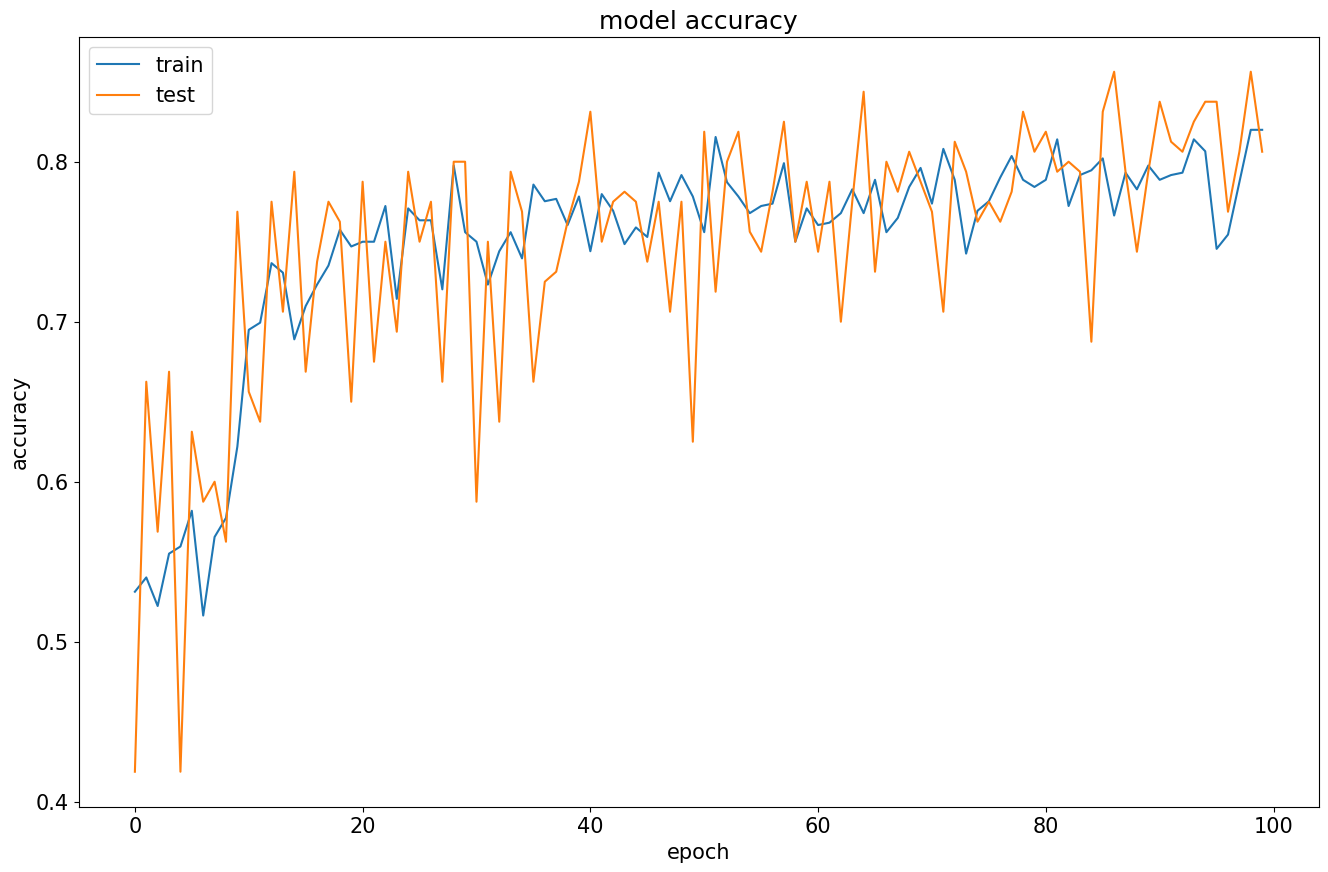

In [53]:
# Build Sequential Model
model3 = tf.keras.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

batch_size = 256
history3 = model3.fit(
        train_gen,
        steps_per_epoch=len(train_gen) // batch_size,
        epochs=100,
        validation_data=val_gen,
        validation_steps=len(val_gen) // batch_size)

#Let's graph this mess
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Still a little better, I'm going to try reducing my batch size. Training time hasn't been too long thus far, and that could help my variation between epoch.

Epoch 1/100
55/55 [==============================] - 4s 79ms/step - loss: 0.4138 - accuracy: 0.8205 - val_loss: 0.4404 - val_accuracy: 0.8053
Epoch 2/100
55/55 [==============================] - 3s 60ms/step - loss: 0.4762 - accuracy: 0.7795 - val_loss: 0.5014 - val_accuracy: 0.7812
Epoch 3/100
55/55 [==============================] - 3s 57ms/step - loss: 0.4682 - accuracy: 0.7864 - val_loss: 0.4511 - val_accuracy: 0.7981
Epoch 4/100
55/55 [==============================] - 4s 74ms/step - loss: 0.4431 - accuracy: 0.8017 - val_loss: 0.4158 - val_accuracy: 0.8173
Epoch 5/100
55/55 [==============================] - 3s 59ms/step - loss: 0.4327 - accuracy: 0.8034 - val_loss: 0.4685 - val_accuracy: 0.8029
Epoch 6/100
55/55 [==============================] - 3s 58ms/step - loss: 0.4360 - accuracy: 0.8023 - val_loss: 0.4385 - val_accuracy: 0.8173
Epoch 7/100
55/55 [==============================] - 3s 59ms/step - loss: 0.4481 - accuracy: 0.7920 - val_loss: 0.4219 - val_accuracy: 0.8341
Epoch 

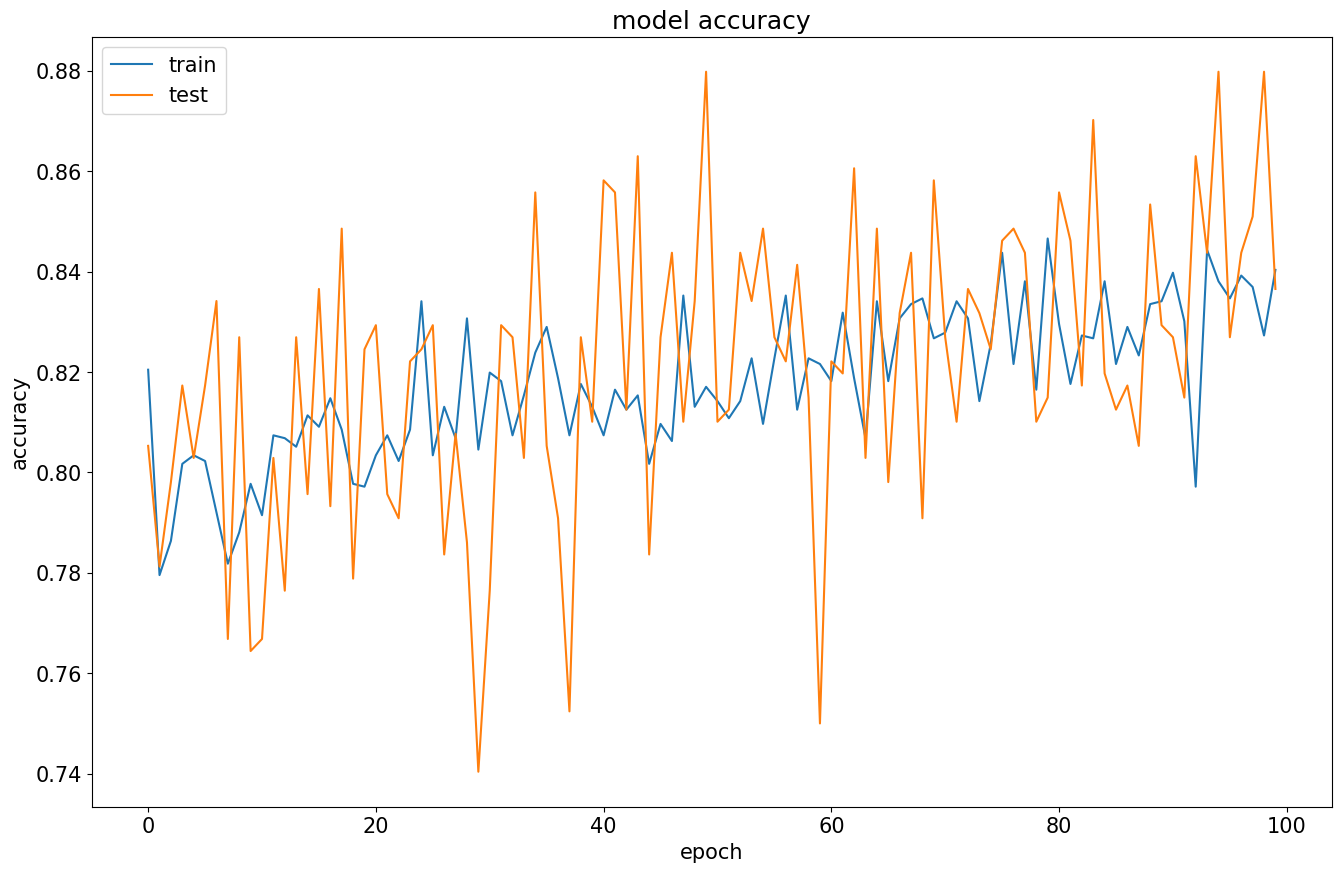

In [54]:
batch_size = 100
history3 = model3.fit(
        train_gen,
        steps_per_epoch=len(train_gen) // batch_size,
        epochs=100,
        validation_data=val_gen,
        validation_steps=len(val_gen) // batch_size)

#Let's graph this mess
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# We're getting there
You can tell reducing the batch size really helped smooth the variation in training data, as expected. It looks like the model could have used a few more epochs but it is still hard to tell with how much variation is in test data. I'll try one more regularization tecnique before calling it a day.

Epoch 1/500
55/55 [==============================] - 9s 77ms/step - loss: 1.5391 - accuracy: 0.6756 - val_loss: 1.7113 - val_accuracy: 0.5986
Epoch 2/500
55/55 [==============================] - 4s 64ms/step - loss: 0.9458 - accuracy: 0.7261 - val_loss: 0.7053 - val_accuracy: 0.6370
Epoch 3/500
55/55 [==============================] - 5s 93ms/step - loss: 1.0741 - accuracy: 0.7216 - val_loss: 0.7153 - val_accuracy: 0.7043
Epoch 4/500
55/55 [==============================] - 4s 66ms/step - loss: 0.9932 - accuracy: 0.7216 - val_loss: 0.6023 - val_accuracy: 0.7957
Epoch 5/500
55/55 [==============================] - 4s 68ms/step - loss: 0.9964 - accuracy: 0.7239 - val_loss: 0.6251 - val_accuracy: 0.8125
Epoch 6/500
55/55 [==============================] - 4s 78ms/step - loss: 1.0149 - accuracy: 0.7409 - val_loss: 0.4839 - val_accuracy: 0.8293
Epoch 7/500
55/55 [==============================] - 4s 64ms/step - loss: 0.8981 - accuracy: 0.7534 - val_loss: 0.6306 - val_accuracy: 0.8173
Epoch 

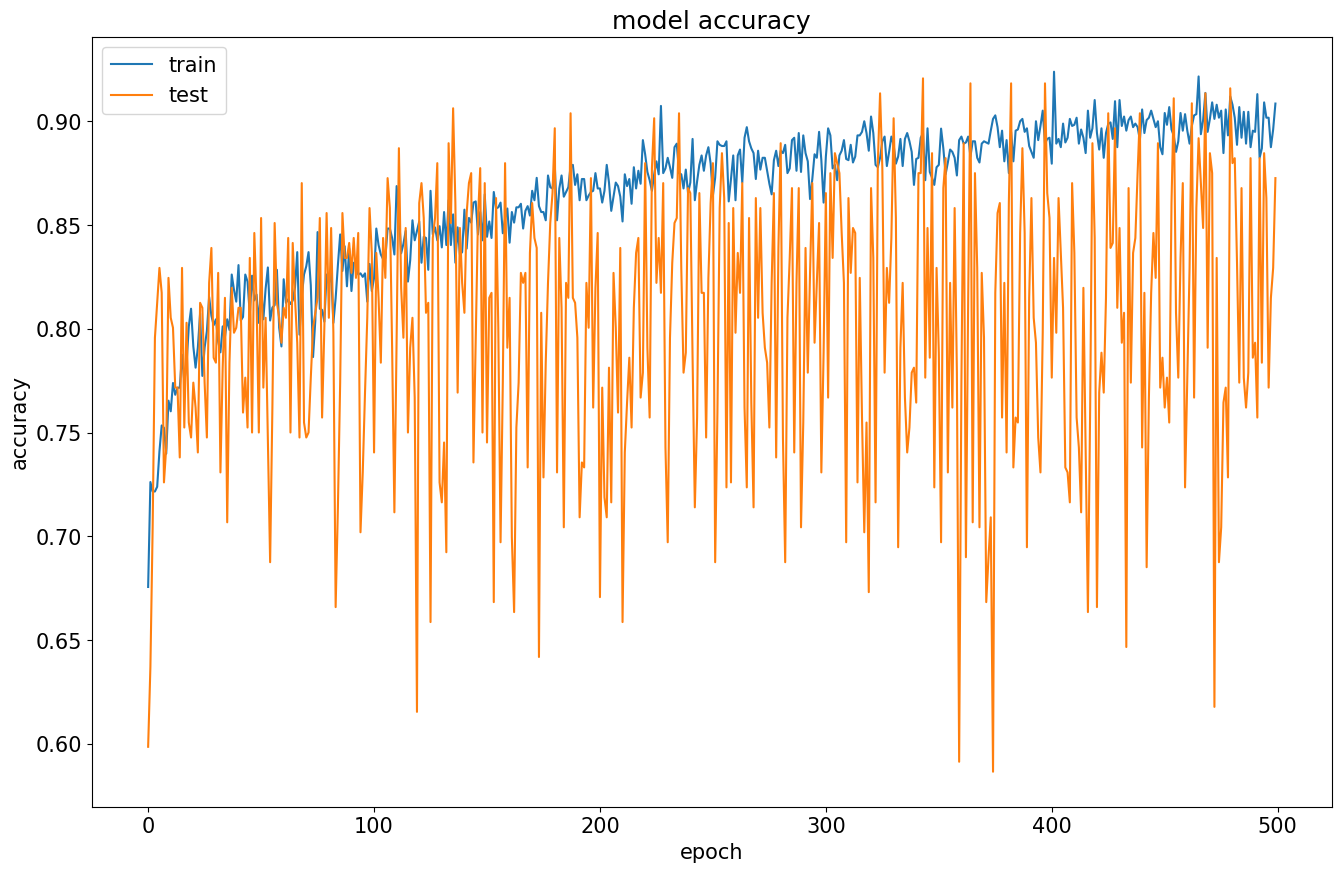

In [56]:
# Build Sequential Model
model3 = tf.keras.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

batch_size = 100
history3 = model3.fit(
        train_gen,
        steps_per_epoch=len(train_gen) // batch_size,
        epochs=500,
        validation_data=val_gen,
        validation_steps=len(val_gen) // batch_size)

#Let's graph this mess
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

A few lessons learned here. Learning rate is probably a little too low, but the bigger problem is whateer is happening with validation accuracy. Some changes: 


*   Add early stopping
*   Lower the strating learning rate a bit
*   Remove a few normalization layers to control time
*   Increace the amount of dropout





Epoch 1/500
55/55 [==============================] - 10s 72ms/step - loss: 1.2813 - accuracy: 0.6438 - val_loss: 0.9243 - val_accuracy: 0.5841
Epoch 2/500
55/55 [==============================] - 3s 61ms/step - loss: 1.1927 - accuracy: 0.6886 - val_loss: 0.5005 - val_accuracy: 0.7668
Epoch 3/500
55/55 [==============================] - 3s 62ms/step - loss: 1.1291 - accuracy: 0.6869 - val_loss: 0.8478 - val_accuracy: 0.5962
Epoch 4/500
55/55 [==============================] - 5s 84ms/step - loss: 1.0694 - accuracy: 0.6932 - val_loss: 0.7959 - val_accuracy: 0.6226
Epoch 5/500
55/55 [==============================] - 3s 61ms/step - loss: 1.0627 - accuracy: 0.6949 - val_loss: 0.8600 - val_accuracy: 0.6034
Epoch 6/500
55/55 [==============================] - 3s 63ms/step - loss: 1.0055 - accuracy: 0.6977 - val_loss: 1.0507 - val_accuracy: 0.6034
Epoch 7/500
55/55 [==============================] - 6s 103ms/step - loss: 1.0356 - accuracy: 0.6915 - val_loss: 1.0470 - val_accuracy: 0.5721
Epoc

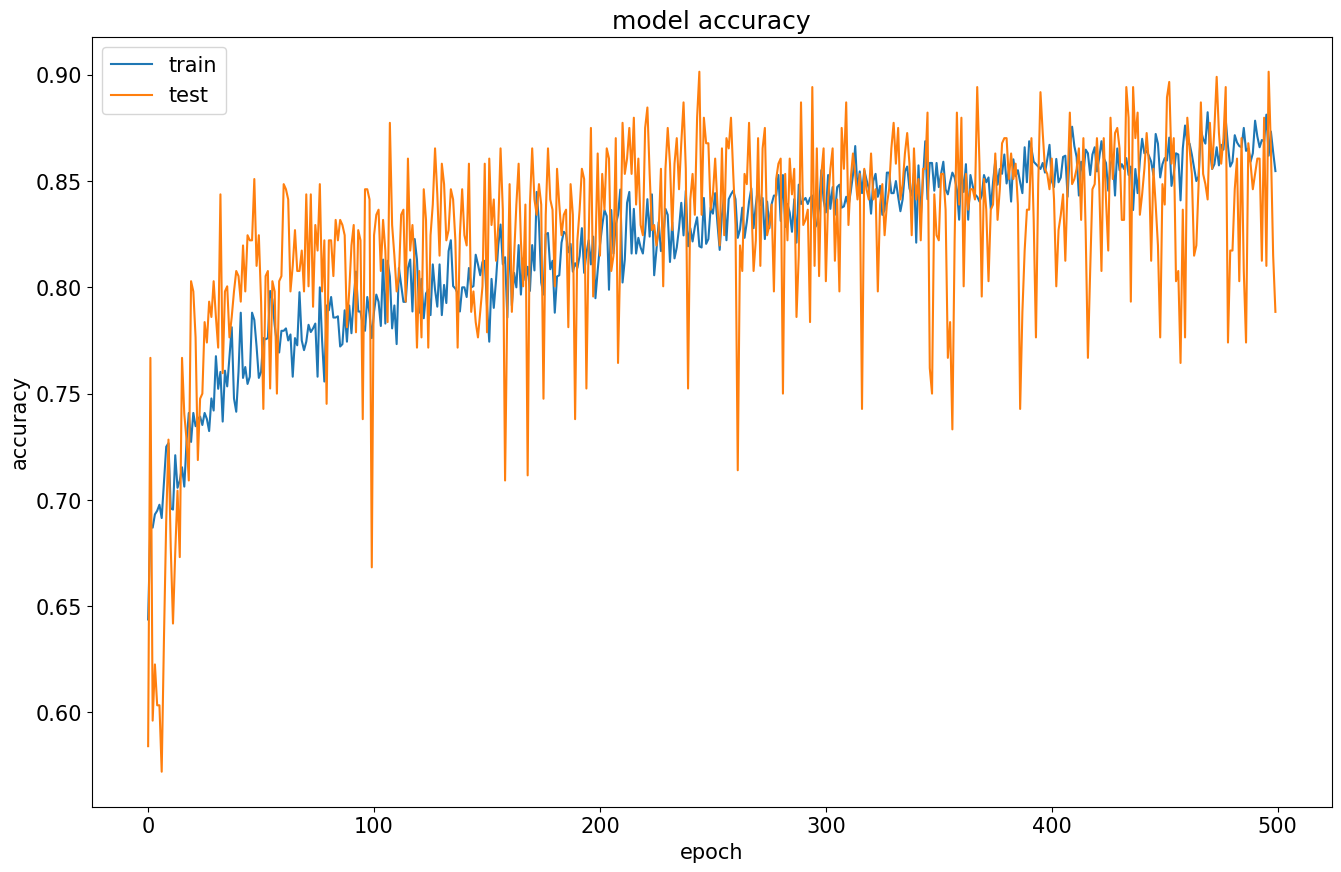

In [58]:
# Build Sequential Model
model4 = tf.keras.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.75),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

batch_size = 100
history4 = model4.fit(
        train_gen,
        steps_per_epoch=len(train_gen) // batch_size,
        epochs=500,
        validation_data=val_gen,
        validation_steps=len(val_gen) // batch_size)

#Let's graph this mess
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Much Better! I think this is my final model

There is still more to be done, I think an even higher dropout could work well, but that would require more training time.

**Final training accuracy: 0.8547**

**Final validation accuracy: 0.7885**

# Training Summary and Conclusions
I began with a simple model to get my neural network legs that reflected the VGGNet structure. From there based on the variation in the epoch-accuracy graphs noted in the analysis I made several more adjustments- lowered learning rate, decreaced batch size, adjusted the optimizer, added more filter layers, added normalization and dropout layers, and finally increaced the dropout rates. 

Overall I believe several tuning parameters were critical in improving my model:


*   Decreacing the learning rate to be able to accurately acess the issues with my model
*   Decreacing batch size allowed me to distinguish whether my issues were in just validation accuracy or also with trainng accuracy
*   Adding (large) dropout layers was they key to being able to generalize my model from training to validation

What didn't really work: Changing the optimizer, normalization

In the future I would try utilizing a prebuilt model to preprocess the images such as ResNet in order to further reduce the variation in validation accuracy. Additionally, I would add more dropout layers and opportunities for teh same reason which would require also probably adding more filters/epochs/training time.




### Predicting Test Data
We have the model with trained weight. So we can evaluate our model performance with test data. Since test dataset is unseen data from model, so its accuracy and loss may be lower than training one.

In [68]:
#upload test data labels
test_labels_df = pd.read_csv("/content/sample_submission.csv")
test_labels_df['id'] = test_labels_df['id'] + '.tif'

print("Number of images in our test data: ",len(test_labels_df))

#Create generator object
test_gen = ImageDataGenerator().flow_from_dataframe(dataframe=test_labels_df,
                                                        directory="/content/test/",
                                                        x_col="id",
                                                        y_col=None,
                                                        target_size=(96, 96),
                                                        batch_size=2,
                                                        shuffle=False,
                                                        class_mode=None)

test_gen.reset()

#predict
preds = model4.predict(test_gen,verbose=1)

Number of images in our test data:  57458
Found 57458 validated image filenames.
28729/28729 [==============================] - 135s 5ms/step


In [70]:
test_labels_df['id'] = test_labels_df['id'].apply(lambda x: x.split('.')[0])
test_labels_df['label'] = preds[:, 0]
test_labels_df.to_csv('submission.csv', index=False)
test_labels_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,2.209302e-02
1,95596b92e5066c5c52466c90b69ff089b39f2737,4.196804e-01
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,4.557597e-16
3,2c35657e312966e9294eac6841726ff3a748febf,1.351085e-03
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,1.669342e-02


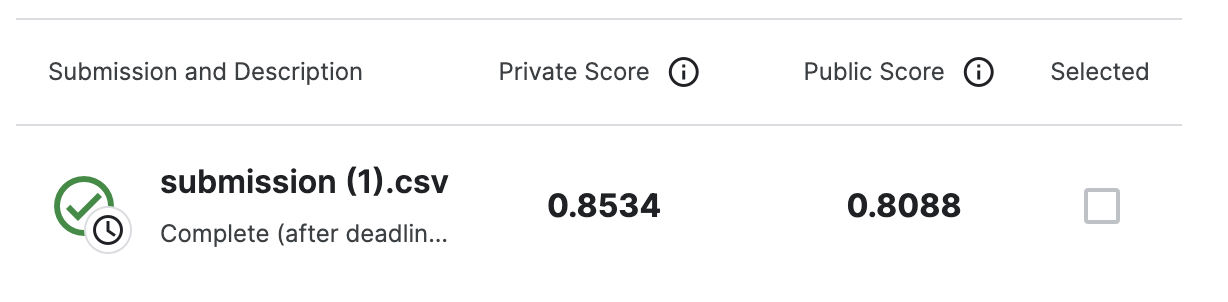